In [2]:
import numpy as np
import matplotlib.pyplot as plt

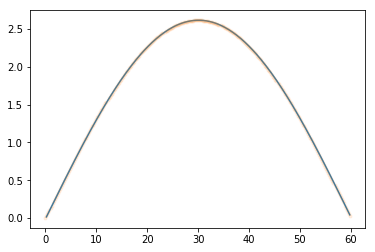

In [9]:
TOTAL_DISTANCE = 100 # meters 

TOTAL_SECONDS = 60 # seconds
SAMPLING_RATE = 5  # Hz
dt = 1 / SAMPLING_RATE

GPS_RMS_ERROR = 1 # meter
ACCELEROMETER_RMS_ERROR = .01 # m/s**2

number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE

t = np.arange(number_of_timesteps) / SAMPLING_RATE

true_acceleration = TOTAL_DISTANCE / 2 * np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))**2
true_velocity = TOTAL_DISTANCE / 2 * np.sin(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))
true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2


plt.plot(t[1:], np.diff(true_position) / dt)
plt.plot(t, true_velocity, '.', alpha=.1)

In [10]:
angle = np.pi / 8 * 2
position_2d = np.zeros((len(true_position), 2))
position_2d[:, 0] = np.cos(angle) * true_position
position_2d[:, 1] = np.sin(angle) * true_position

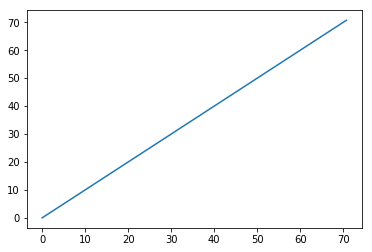

In [11]:
plt.plot(position_2d[:,0], position_2d[:, 1])

In [19]:
np.random.seed(52)
sensor_position = np.zeros((number_of_timesteps, 3))
sensor_position[:, 0] = np.cos(angle) * true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR
sensor_position[:, 1] = np.sin(angle) * true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR
sensor_position[:, 2] = GPS_RMS_ERROR

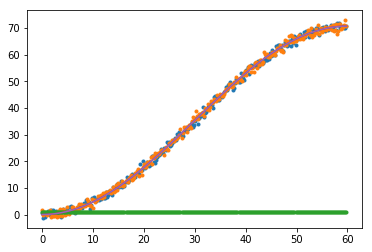

In [20]:
plt.plot(t, sensor_position, '.')
plt.plot(t, position_2d)

In [69]:
Q_pos = 0
Q_vel = 2
Q_ang = .001

number_of_states = 9

Q = np.array([
    [Q_pos, 0, 0, 0, 0, 0,  0, 0, 0],
    [0, Q_pos, 0, 0, 0, 0,  0, 0, 0],    
    [0, 0, Q_pos, 0, 0, 0,  0, 0, 0],
    [0, 0, 0, Q_vel, 0, 0,  0, 0, 0],
    [0, 0, 0, 0, Q_vel, 0,  0, 0, 0],
    [0, 0, 0, 0, 0, Q_vel,  0, 0, 0], 
    [0, 0, 0, 0, 0, 0,  Q_ang, 0, 0],  
    [0, 0, 0, 0, 0, 0,  0, Q_ang, 0],  
    [0, 0, 0, 0, 0, 0,  0, 0, Q_ang],  
])    

H = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
])

R = np.array([
    [GPS_RMS_ERROR, 0, 0],
    [0, GPS_RMS_ERROR, 0],    
    [0, 0, GPS_RMS_ERROR]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([0, 0, 0, 0, 0, 0, angle, 0, 0])
P = np.array([
    [GPS_RMS_ERROR**2, 0, 0,  0, 0, 0,  0, 0, 0],
    [0, GPS_RMS_ERROR**2, 0,  0, 0, 0,  0, 0, 0],
    [0, 0, GPS_RMS_ERROR**2,  0, 0, 0,  0, 0, 0],
    [0, 0, 0,  Q_vel, 0, 0,  0, 0, 0],
    [0, 0, 0,  0, Q_vel, 0,  0, 0, 0],
    [0, 0, 0,  0, 0, Q_vel,  0, 0, 0],
    [0, 0, 0,  0, 0, 0,  Q_ang, 0, 0],
    [0, 0, 0,  0, 0, 0,  0, Q_ang, 0],
    [0, 0, 0,  0, 0, 0,  0, 0, Q_ang],
])
for time_index in range(number_of_timesteps):
    # Kalman step

    rX, rX, rX, _, _, _, yaw, pitch, roll = mu     
    vx, vy, vz = u
    u = np.stack([true_velocity[time_index], 0, 0])
    
    def f(mu, u):
        
        #rX, rX, rX, _, _, _, vZ, yaw, pitch, roll = mu   
        
        # Update based on velocity
        mu[0:3] += dt * mu[3:6]
        mu[0] += dt * (vx * np.cos(yaw) + vy * np.sin(yaw))
        mu[1] += dt * (vx * (-np.sin(yaw)) + vy * np.cos(yaw))
        
        # Update with sensor input
        return mu

    F = np.array([
        [1, 0, 0,  dt, 0, 0,  -vx*np.sin(yaw) + vy * np.cos(yaw), 0, 0],
        [0, 1, 0,  0, dt, 0,  -np.cos(yaw) - vy * np.sin(yaw), 0, 0],
        [0, 0, 1,  0, 0, dt,  0, 0, 0],
        
        [0, 0, 0,  1, 0, 0,  0, 0, 0],
        [0, 0, 0,  0, 1, 0,  0, 0, 0],
        [0, 0, 0,  0, 0, 1,  0, 0, 0],
        
        [0, 0, 0,  0, 0, 0,  1, 0, 0],
        [0, 0, 0,  0, 0, 0,  0, 1, 0],
        [0, 0, 0,  0, 0, 0,  0, 0, 1],
    ])    
    
    z = sensor_position[time_index, :]

    #print(z)

    # Predict
    mu_model = f(mu, v)
    P = F @ P @ F.T + Q

    # Update
    y = z - H @ mu_model # pre-fit residual
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual



    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

$ x[t+1] = x[t] + v[t] \cdot \cos(\theta[t]) * dt $

$ dx = 1 \cdot \mathbf{x} + \cos \theta dt \mathbf{v} + - v dt \sin \theta \mathbf{\theta} $

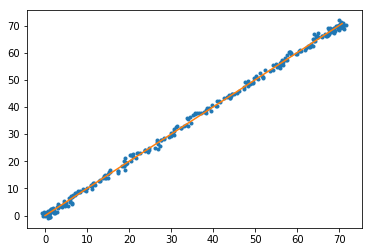

In [70]:
plt.plot(kalman_states[:, 0], kalman_states[:, 1], '.')
plt.plot(position_2d[:, 0], position_2d[:, 1])

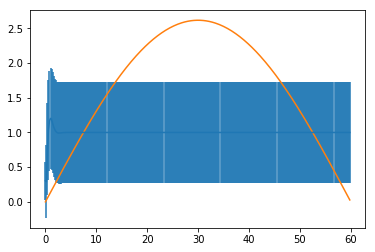

In [71]:
idx = 2
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
plt.plot(t, true_velocity)

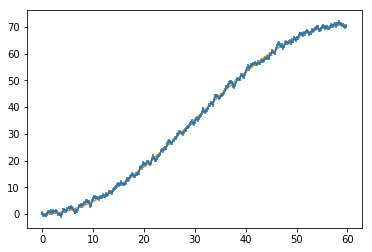

In [72]:
idx = 0
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
plt.plot(t, position_2d[:, 0])

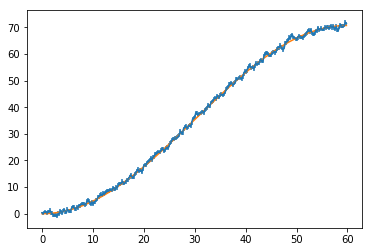

In [73]:
idx = 1
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
plt.plot(t, position_2d[:, 1])

<ErrorbarContainer object of 3 artists>

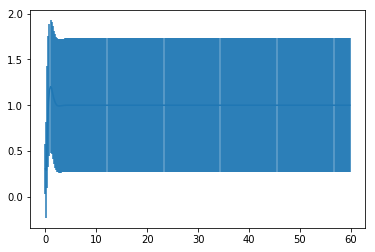

In [74]:
idx = 2
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
#plt.plot(t, position_2d[:, 1])

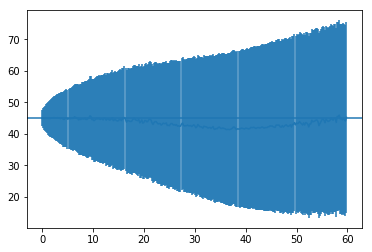

In [75]:
idx = 6
plt.errorbar(t, kalman_states[:, idx]*180/np.pi, kalman_errors[:, idx]*180/np.pi)
plt.axhline(angle*180/np.pi)
#plt.plot(t, position_2d[:, 1])

In [783]:
F = np.array([
    [1, dt],
    [0, 1],
])

Q_pos = .0001
Q_vel = .00001

Q = np.array([
    [Q_pos, 0],
    [0, Q_vel],
])



H = np.array([
    [1, 0],
])


In [687]:
def get_l2_norm_for_Q(Q_pos, Q_vel):
    
    Q = np.array([
        [Q_pos, 0],
        [0, Q_vel],
    ])    

    R = np.array([
        [GPS_RMS_ERROR, ]
    ]) ** 2    
    
    kalman_states = np.empty((number_of_timesteps, 2)) * np.nan
    kalman_errors = np.empty((number_of_timesteps, 2)) * np.nan

    I = np.identity(2)

    # initialize state
    mu = np.array([0, 0])
    P = np.array([
        [GPS_RMS_ERROR**2, 0],
        [0, 0],
    ])
    for time_index in range(number_of_timesteps):
        # Kalman step

        z = np.array([sensor_position[time_index]])

        #print(z)

        # Predict
        mu_model = F @ mu
        P = F @ P @ F.T + Q

        # Update
        y = z - H @ mu_model # pre-fit residual
        K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
        #print(time_index, K)
        mu = mu_model + K @ y
        P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
        y = z - H @ mu # post-fit residual



        kalman_states[time_index,:] = mu
        kalman_errors[time_index,:] = P.diagonal()**.5

    residual = kalman_states[:,0] - true_position
        
    l2_norm = np.sum(residual**2) / number_of_timesteps
    return l2_norm ** .5 

In [9]:
TOTAL_DISTANCE = 100 # meters 

TOTAL_SECONDS = 60 # seconds
SAMPLING_RATE = 10  # Hz
dt = 1 / SAMPLING_RATE

GPS_RMS_ERROR = GPS_error
number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
t = np.arange(number_of_timesteps) / SAMPLING_RATE

true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
true_velocity = TOTAL_DISTANCE / 2 * np.sin(2 * np.pi * t / (2 * TOTAL_SECONDS) ) * (2 * np.pi / (2 * TOTAL_SECONDS))

np.random.seed(52) 
sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

Q = np.array([
    [0, 0],
    [0, .0001],
])    

R = np.array([
    [GPS_RMS_ERROR, ]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, 2)) * np.nan
kalman_errors = np.empty((number_of_timesteps, 2)) * np.nan

I = np.identity(2)

# initialize state
mu = np.array([0, 0])
P = np.array([
    [GPS_RMS_ERROR**2, 0],
    [0, 0],
])
for time_index in range(number_of_timesteps):
    # Kalman step

    z = np.array([sensor_position[time_index]])

    #print(z)

    # Predict
    mu_model = F @ mu
    P = F @ P @ F.T + Q

    # Update
    y = z - H @ mu_model # pre-fit residual
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    #print(time_index, K)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual



    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5
    
    
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.plot(t, kalman_states[:, 0])
ax1.plot(t, true_position)

ax2.plot(t, kalman_states[:, 1])
ax2.plot(t, true_velocity * dt)

NameError: name 'GPS_error' is not defined

In [142]:
Q_pos_arr = np.logspace(-8, 2, 10)
Q_vel_arr = np.logspace(-8, 1, 10)

In [143]:
Qs = np.meshgrid(Q_pos_arr, Q_vel_arr)[0]

In [144]:
l2_norms = np.empty(Qs.shape)
l2_norms[:, :] = np.nan

In [145]:
for row, Q_pos in enumerate(Q_pos_arr):
    for col, Q_vel in enumerate(Q_vel_arr):
        l2_norms[row, col] = get_l2_norm_for_Q(Q_pos, Q_vel)

Text(0.5, 0, 'Q_vel')

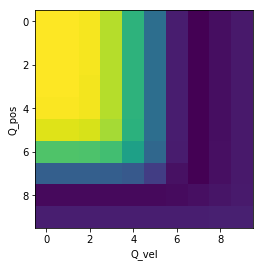

In [146]:
plt.imshow(np.log10(l2_norms))
plt.ylabel('Q_pos')
plt.xlabel('Q_vel')

Text(0.5, 0, '$Q_{vel}$ $(m/s)^2$')

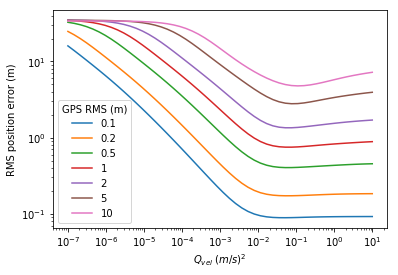

In [187]:
for GPS_error in [.1, .2, .5, 1, 2, 5, 10]: 
    TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = 1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = GPS_error
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
        
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

    
    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=GPS_error)
plt.legend(loc='best', title=('GPS RMS (m)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')

array([-0.46179356, -0.12621527,  0.15325446, -0.15956678])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


Text(0.5, 0, '$Q_{vel}$ $(m/s)^2$')

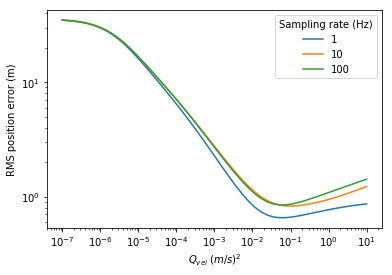

In [222]:

for sampling_rate in [1, 10, 100]: 
    TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = sampling_rate #1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = 1 #* SAMPLING_RATE **.5
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_noise_raw = np.random.randn(TOTAL_SECONDS * 100) * GPS_RMS_ERROR * 100**.5
    sensor_noise_downsampled = np.mean(
        sensor_noise_raw.reshape(-1 , number_of_timesteps), 
        axis=0)
    sensor_position = true_position + sensor_noise_downsampled

    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel / sampling_rate**4) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=sampling_rate)
plt.legend(loc='best', title=('Sampling rate (Hz)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')

Text(0.5, 0, '$Q_{vel}$ $(m/s)^2$')

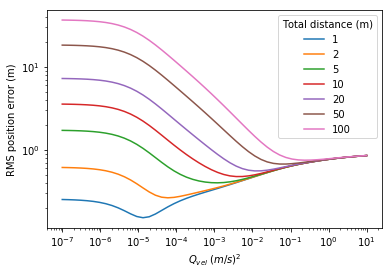

In [177]:
for TOTAL_DISTANCE in [1, 2, 5, 10, 20, 50, 100]:
    #TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = 1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = 1 * SAMPLING_RATE ** .5
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

    
    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=TOTAL_DISTANCE)
plt.legend(loc='best', title=('Total distance (m)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')

Text(0.5, 1.0, 'GPS error scaled as percentage of position variation')

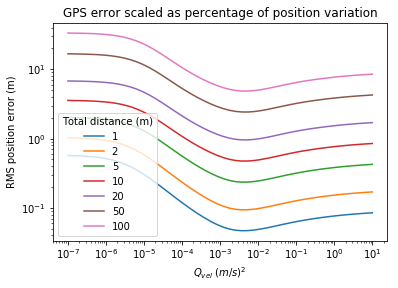

In [179]:
for TOTAL_DISTANCE in [1, 2, 5, 10, 20, 50, 100]:
    #TOTAL_DISTANCE = 100 # meters 

    TOTAL_SECONDS = 60 # seconds
    SAMPLING_RATE = 1  # Hz
    dt = 1 / SAMPLING_RATE

    GPS_RMS_ERROR = .1 * TOTAL_DISTANCE * SAMPLING_RATE ** .5
    number_of_timesteps = TOTAL_SECONDS * SAMPLING_RATE
    t = np.arange(number_of_timesteps) / SAMPLING_RATE
    true_position = TOTAL_DISTANCE * ( 1 - np.cos(2 * np.pi * t / (2 * TOTAL_SECONDS))) / 2
    np.random.seed(52) 
    sensor_position = true_position + np.random.randn(number_of_timesteps) * GPS_RMS_ERROR    

    
    Q_vel_list = np.logspace(-7, 1)
    l2_norm_list = np.array([get_l2_norm_for_Q(0, Q_vel) for Q_vel in Q_vel_list])

    plt.loglog(Q_vel_list, l2_norm_list, label=TOTAL_DISTANCE)
plt.legend(loc='best', title=('Total distance (m)'))
plt.ylabel('RMS position error (m)')
plt.xlabel(r'$Q_{vel}$ $(m/s)^2$')
plt.title('GPS error scaled as percentage of position variation')

In [47]:
get_l2_norm_for_Q(.01, .001)

61.99467572122603

In [44]:
#kalman_index = 0
#plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
#plt.plot(t, true_position)

In [38]:
residual = kalman_states[:, 0] - true_position

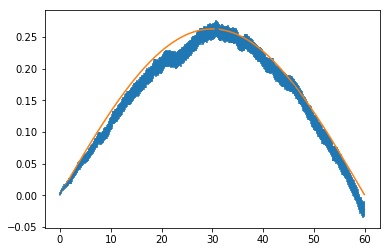

In [23]:
kalman_index = 1
plt.errorbar(t, (kalman_states[:, kalman_index]), kalman_errors[:, kalman_index])
plt.plot(t, np.cumsum(true_acceleration) * dt)

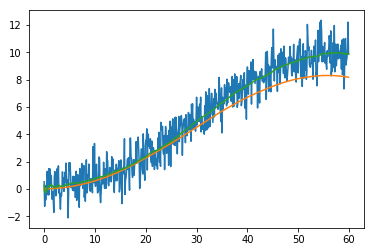

In [24]:
plt.plot(t, position_estimate_gps_only)
plt.plot(t, position_estimate_accelerometer_only)
plt.plot(t, kalman_states[:, 0])

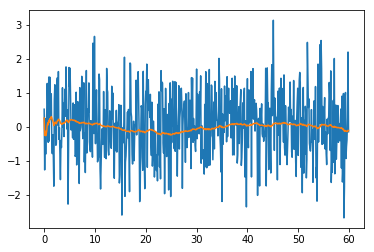

In [25]:
plt.plot(t, position_estimate_gps_only - true_position)
plt.plot(t, kalman_states[:, 0] - true_position)
#plt.plot(t, kalman_states[:, 0])

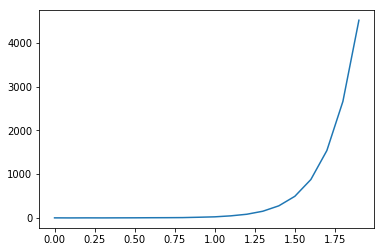

In [267]:
s = slice(0,20)
plt.plot(t[s], kalman_states[s, 2])

In [260]:
kalman_states[60:90, 0]

array([ 9.06250e-01, -6.25000e-01, -6.25000e-01,  1.25000e+00,
       -1.00000e+00,  0.00000e+00,  1.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00, -1.60000e+01,
       -3.20000e+01,  0.00000e+00, -3.20000e+01,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  0.00000e+00,  0.00000e+00,
        0.00000e+00,  0.00000e+00,  5.24288e+05,  0.00000e+00,
        0.00000e+00,  0.00000e+00])

In [214]:
np.argmin(kalman_states[:, 0])

120

In [217]:
kalman_states[119, 0]

-35184372088832.0